In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [4]:
data_path = '/shared/TORCS_train.tfrecords'

feature = {'fast': tf.FixedLenFeature([], tf.float32),
    'dist_RR': tf.FixedLenFeature([], tf.float32),
    'dist_MM': tf.FixedLenFeature([], tf.float32),
    'dist_LL': tf.FixedLenFeature([], tf.float32),
    'toMarking_RR': tf.FixedLenFeature([], tf.float32),
    'toMarking_MR': tf.FixedLenFeature([], tf.float32),
    'toMarking_ML': tf.FixedLenFeature([], tf.float32),
    'toMarking_LL': tf.FixedLenFeature([], tf.float32),
    'dist_R': tf.FixedLenFeature([], tf.float32),
    'dist_L': tf.FixedLenFeature([], tf.float32),
    'toMarking_R': tf.FixedLenFeature([], tf.float32),
    'toMarking_M': tf.FixedLenFeature([], tf.float32),
    'toMarking_L': tf.FixedLenFeature([], tf.float32),
    'angle': tf.FixedLenFeature([], tf.float32),
    'image': tf.FixedLenFeature([], tf.string)}

# Create a list of filenames and pass it to a queue
filename_queue = tf.train.string_input_producer([data_path], num_epochs=1)
# Define a reader and read the next record
reader = tf.TFRecordReader()
_, serialized_example = reader.read(filename_queue)
# Decode the record read by the reader
features = tf.parse_single_example(serialized_example, features=feature)
# Convert the image data from string back to the numbers
image = tf.decode_raw(features['image'], tf.uint8)

# Cast label data into float32
fast = tf.cast(features['fast'], tf.float32)

# rescale all targets to [0,1], numbers were taken from source code of DeepDriving
dist_RR = tf.cast(features['dist_RR'], tf.float32) / 95.0 + 0.12
dist_MM = tf.cast(features['dist_MM'], tf.float32) / 95.0 + 0.12
dist_LL = tf.cast(features['dist_LL'], tf.float32) / 95.0 + 0.12

toMarking_RR = tf.cast(features['toMarking_RR'], tf.float32) / 6.8752 - 0.48181
toMarking_MR = tf.cast(features['toMarking_MR'], tf.float32) / 6.25 + 0.02
toMarking_ML = tf.cast(features['toMarking_ML'], tf.float32) / 6.25 + 0.98
toMarking_LL = tf.cast(features['toMarking_LL'], tf.float32) / 6.8752 + 1.48181

dist_R = tf.cast(features['dist_R'], tf.float32) / 95.0 + 0.12
dist_L = tf.cast(features['dist_L'], tf.float32) / 95.0 + 0.12

toMarking_R = tf.cast(features['toMarking_R'], tf.float32) / 5.6249 - 0.34445
toMarking_M = tf.cast(features['toMarking_M'], tf.float32) / 6.8752 + 0.39091
toMarking_L = tf.cast(features['toMarking_L'], tf.float32) / 5.6249 + 1.34445

angle = tf.cast(features['angle'], tf.float32) / 1.1 + 0.5

# Reshape image data into the original shape
image = tf.reshape(image, [210, 280, 3])

# Any preprocessing here ...
image = tf.cast(image, tf.float32)
image = (image - 128.0) / 128.0

# Creates batches by randomly shuffling tensors

images = tf.train.shuffle_batch([image], batch_size=1, capacity=30, num_threads=1, min_after_dequeue=10)


In [5]:
from alexnet import alexnet_v2


logits, endpoints = alexnet_v2(images,
               num_classes=1000,
               is_training=True,
               dropout_keep_prob=0.99,
               spatial_squeeze=True,
               scope='alexnet_v2')

y_pred = endpoints['alexnet_v2/fc8']

attention = []
for i in range(14):
    attention.append(tf.gradients([y_pred[0,i]], [images]))

INFO:tensorflow:Restoring parameters from /shared/swap/model_alex/139999.ckpt


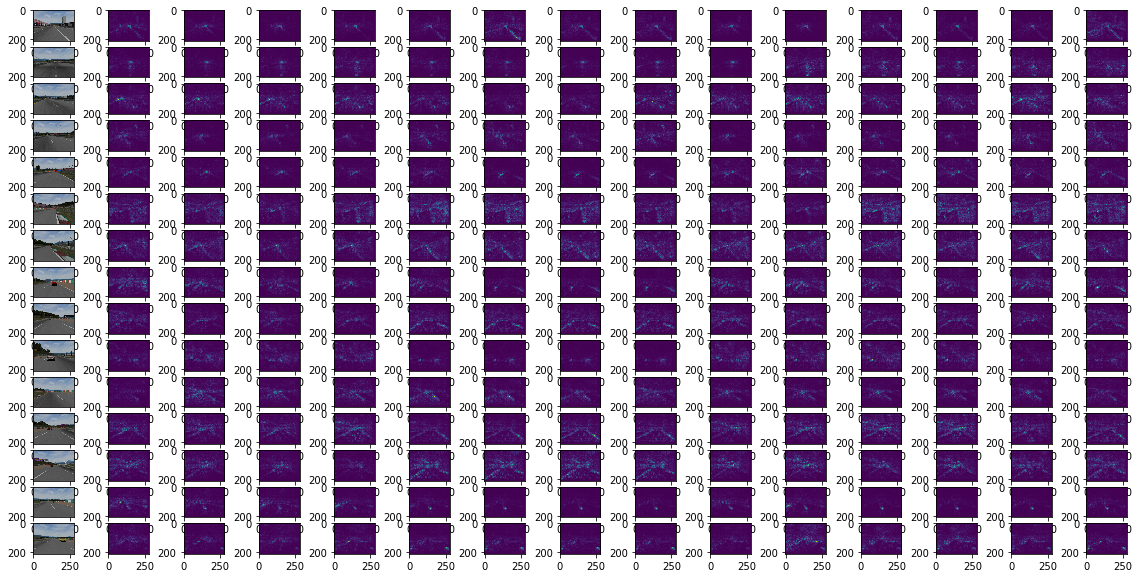

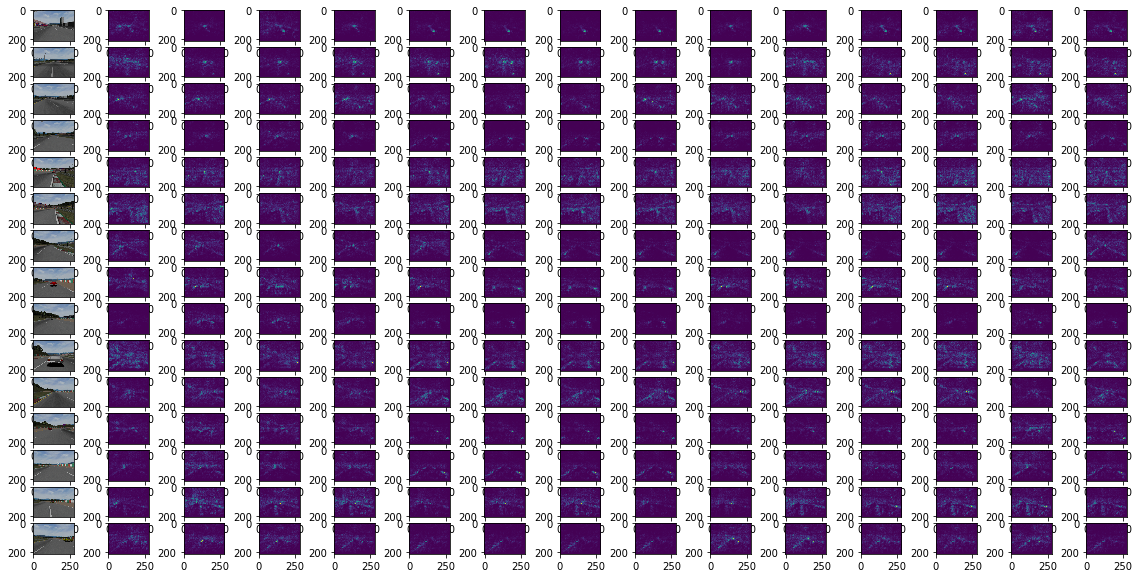

In [22]:
with tf.Session() as sess:
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init_op)
    # restore model
    saver = tf.train.Saver()

    saver.restore(sess, '/shared/swap/model_alex/139999.ckpt')
    
    # Create a coordinator and run all QueueRunner objects
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)

    fig, ax = plt.subplots(nrows=15, ncols=15, figsize=(20,10))
    
    hist = []
    
    for j in range(1500):
        if j % 100:
            sess.run([images])
            continue
        batch_index = int(j / 100)
        img, att = sess.run([images, attention])
        hist.append((img, att))
        ax[batch_index][0].imshow(np.asarray(img[0,:,:,::-1]*128+128,dtype=np.uint8))
        #ax[batch_index][1].imshow(np.asarray(np.abs(att[0][0,...]) > 0.01, dtype=np.float32))
        for i in range(14):
            ax[batch_index][i + 1].imshow(np.sum(np.abs(att[i][0][0,...]), axis=2))
            
    # Stop the threads
    coord.request_stop()
    plt.show()

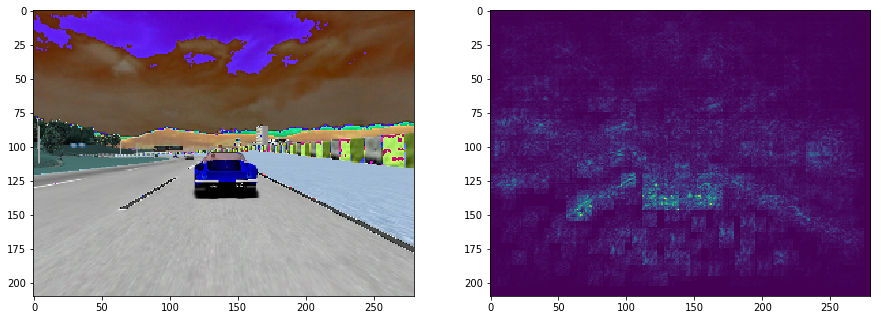

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,10))

ind = 7

ax[0].imshow(np.asarray(hist[ind][0][0,...]*128.0+128.0, dtype=np.uint8))
ax[1].imshow(np.sum(np.abs(hist[ind][1][2][0][0,...]), axis=2))
plt.show()